# Práctica Imagen

Francisco Rodríguez Cuenca

El objetivo de esta práctica es el desarrollo de un modelo que pueda diferenciar entre películas de animación y vida real a partir de sus posters.

Para ello hemos realizado cuatro modelos, todos utilizando una red base VGG16: uno con la red congelada y otros tres con diferentes niveles de descongelación.

Al final nuestro mejor modelo ha sido el último que hemos probado: descongelando únicamente la última red convolucional del VGG16.

Debido al poco tamaño de nuestra muestra, los modelos se sobreentrenaban con facilidad así que hemos limitado las epochs a 30.

### Configuración

In [1]:
import keras
keras.__version__

'2.4.3'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
base_dir = base_dir = 'data'

train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')

Found 2115 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Primer modelo

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
conv_base.trainable = False

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 - 59s - loss: 0.6371 - acc: 0.6371 - val_loss: 0.5991 - val_acc: 0.6920
Epoch 2/30
100/100 - 62s - loss: 0.5581 - acc: 0.7083 - val_loss: 0.5146 - val_acc: 0.7520
Epoch 3/30
100/100 - 62s - loss: 0.5174 - acc: 0.7499 - val_loss: 0.5624 - val_acc: 0.7320
Epoch 4/30
100/100 - 62s - loss: 0.4960 - acc: 0.7589 - val_loss: 0.5314 - val_acc: 0.7760
Epoch 5/30
100/100 - 62s - loss: 0.4856 - acc: 0.7629 - val_loss: 0.5195 - val_acc: 0.7640
Epoch 6/30
100/100 - 61s - loss: 0.4852 - acc: 0.7694 - val_loss: 0.4968 - val_acc: 0.7680
Epoch 7/30
100/100 - 61s - loss: 0.4700 - acc: 0.7719 - val_loss: 0.5197 - val_acc: 0.7480
Epoch 8/30
100/100 - 61s - loss: 0.4594 - acc: 0.7865 - val_loss: 0.5249 - val_acc: 0.7360
Epoch 9/30
100/100 - 61s - loss: 0.4419 - acc: 0.7910 - val_loss: 0.5663 - val_acc: 0.7760
Epoch 10/30
100/100 - 61s - loss: 0.4639 - acc: 0.7865 - val_loss: 0.5273 - val_acc: 0.7480
Epoch 11/30
1

In [8]:
model.save('posters.h5')

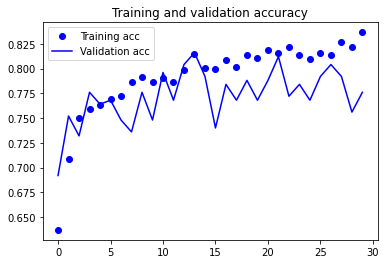

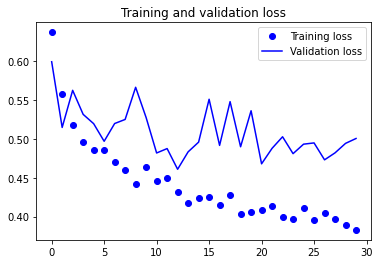

In [9]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.7639999985694885


## Fine tuning - Segundo modelo

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 74s 737ms/step - loss: 0.4175 - acc: 0.7925 - val_loss: 0.5564 - val_acc: 0.7240
Epoch 2/30
100/100 [==============================] - 74s 737ms/step - loss: 0.3857 - acc: 0.8266 - val_loss: 0.4807 - val_acc: 0.7560
Epoch 3/30
100/100 [==============================] - 74s 736ms/step - loss: 0.3497 - acc: 0.8536 - val_loss: 0.4851 - val_acc: 0.7800
Epoch 4/30
100/100 [==============================] - 74s 737ms/step - loss: 0.3335 - acc: 0.8506 - val_loss: 0.4802 - val_acc: 0.7880
Epoch 5/30
100/100 [==============================] - 74s 739ms/step - loss: 0.3231 - acc: 0.8665 - val_loss: 0.4946 - val_acc: 0.7840
Epoch 6/30
100/100 [==============================] - 74s 736ms/step - loss: 0.2956 - acc: 0.8767 - val_loss: 0.6034 - val_acc: 0.7360
Epoch 7/30
100/100 [==============================] - 74s 737ms/step - loss: 0.3170 - acc: 0.8707 - val_loss: 0.4257 - val_acc: 0.8040
Epoch 8/30
100/100 [==============================] - 7

In [13]:
model.save('posters_conv1.h5')

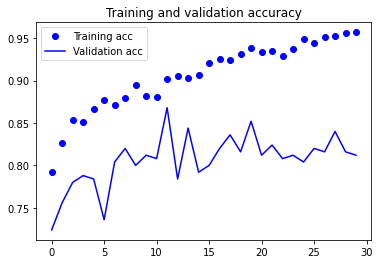

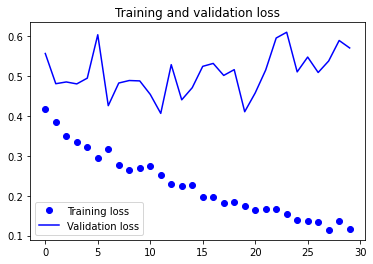

In [14]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.8119999766349792


## Fine tuning - Tercer modelo

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 68s 682ms/step - loss: 0.1059 - acc: 0.9554 - val_loss: 0.4868 - val_acc: 0.8560
Epoch 2/30
100/100 [==============================] - 68s 682ms/step - loss: 0.1019 - acc: 0.9614 - val_loss: 0.5365 - val_acc: 0.8200
Epoch 3/30
100/100 [==============================] - 68s 684ms/step - loss: 0.0941 - acc: 0.9624 - val_loss: 0.5311 - val_acc: 0.8360
Epoch 4/30
100/100 [==============================] - 68s 684ms/step - loss: 0.1014 - acc: 0.9639 - val_loss: 0.6964 - val_acc: 0.7960
Epoch 5/30
100/100 [==============================] - 68s 685ms/step - loss: 0.0902 - acc: 0.9680 - val_loss: 0.6528 - val_acc: 0.8200
Epoch 6/30
100/100 [==============================] - 68s 683ms/step - loss: 0.0950 - acc: 0.9694 - val_loss: 0.5962 - val_acc: 0.8280
Epoch 7/30
100/100 [==============================] - 68s 683ms/step - loss: 0.0861 - acc: 0.9689 - val_loss: 0.7763 - val_acc: 0.7720
Epoch 8/30
100/100 [==============================] - 6

In [18]:
model.save('posters_conv2.h5')

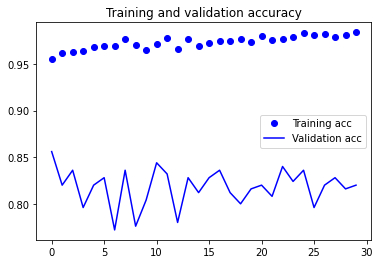

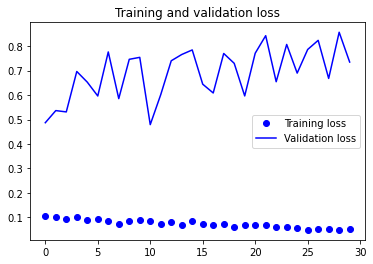

In [19]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.8240000009536743


## Fine tuning - Cuarto modelo

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 63s 632ms/step - loss: 0.0431 - acc: 0.9860 - val_loss: 0.6385 - val_acc: 0.8360
Epoch 2/30
100/100 [==============================] - 63s 632ms/step - loss: 0.0405 - acc: 0.9880 - val_loss: 0.7490 - val_acc: 0.8360
Epoch 3/30
100/100 [==============================] - 63s 632ms/step - loss: 0.0394 - acc: 0.9855 - val_loss: 0.9046 - val_acc: 0.8080
Epoch 4/30
100/100 [==============================] - 63s 633ms/step - loss: 0.0342 - acc: 0.9900 - val_loss: 0.8062 - val_acc: 0.8120
Epoch 5/30
100/100 [==============================] - 63s 632ms/step - loss: 0.0512 - acc: 0.9835 - val_loss: 0.8014 - val_acc: 0.8200
Epoch 6/30
100/100 [==============================] - 63s 634ms/step - loss: 0.0325 - acc: 0.9885 - val_loss: 0.9386 - val_acc: 0.7840
Epoch 7/30
100/100 [==============================] - 63s 633ms/step - loss: 0.0387 - acc: 0.9865 - val_loss: 0.6487 - val_acc: 0.8520
Epoch 8/30
100/100 [==============================] - 6

In [23]:
model.save('posters_conv3.h5')

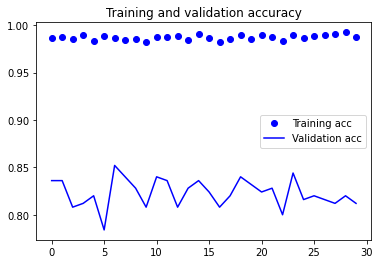

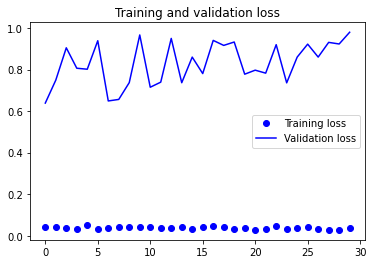

In [24]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.8320000171661377
